In [5]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [ ]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from scipy.signal import fftconvolve
from scipy.fft import rfft2, irfft2, ifftshift
from scipy.optimize import curve_fit
from numba import njit
import glob
import gc
import warnings
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table
from astropy.nddata import Cutout2D
from astropy.wcs.utils import proj_plane_pixel_scales
import astropy.units as u
from tqdm import tqdm
warnings.filterwarnings("ignore")

@njit
def gaussian_weight(height: int, width: int, xc: float = 0, yc: float = 0, sigma: float = 1) -> np.ndarray:
    """
    Calculate Gaussian weight function

    Parameters
    ----------
    height: int
        Height of the weight function in pixels
    width: int
        Width of the weight function in pixels
    xc: float, optional
        x coordinate of the center of the weight function in pixels
    yc: float, optional
        y coordinate of the center of the weight function in pixels
    sigma: float, optional
        Scale parameter of the weight function

    Returns
    -------
    np.ndarray:
        Weight function
    """

    # Create an array for the x and y direction
    x = np.arange(width)
    y = np.arange(height)

    # Calculate the Gaussian in the x and y direction
    gx = np.exp(-0.5 * ((x - xc) / sigma) ** 2)
    gy = np.exp(-0.5 * ((y - yc) / sigma) ** 2)

    # Combining the x and y direction to make a 2D Gaussian
    return gy[:, None] * gx[None, :]

def padded_cutout_with_center(image: np.ndarray, cx: float, cy: float, size: int) -> tuple[np.ndarray, tuple[float, float]]:
    """
    Extract a fixed-size cutout centered on (cy, cx).
    Pads with zeros when the cutout extends beyond the image.

    Parameters
    ----------
    image: np.ndarray
        Image from which the cutout is extracted
    cx: float
        x coordinate of the center of the cutout in the origal image
    cy: float
        y coordinate of the center of the cutout in the origal image
    size: int
        Size of the cutout

    Returns
    -------
    np.ndarray:
        Cutout
    tuple[float, float]:
        Center corresponding to (cx, cy) in the cutout

    Raises
    ------
    ValueError
        Description of when this error is raised
    """

    h, w = image.shape
    half = size // 2

    # Integer anchor
    iy = np.int64(np.floor(cy))
    ix = np.int64(np.floor(cx))

    # Desired bounds in image coordinates
    y0 = iy - half
    x0 = ix - half
    y1 = y0 + size
    x1 = x0 + size

    # Overlap with image
    iy0 = max(0, y0)
    ix0 = max(0, x0)
    iy1 = min(h, y1)
    ix1 = min(w, x1)

    # Corresponding region in cutout coordinates
    cy0 = iy0 - y0
    cx0 = ix0 - x0
    cy1 = cy0 + (iy1 - iy0)
    cx1 = cx0 + (ix1 - ix0)

    # Allocate cutout
    cutout = np.zeros((size, size))

    # Insert image data
    cutout[cy0:cy1, cx0:cx1] = image[iy0:iy1, ix0:ix1]

    # Center in cutout coordinates
    cy_c = cy - y0
    cx_c = cx - x0

    return cutout, (cx_c, cy_c)


def create_psf(
    image: np.ndarray,
    catalog: Table,
    psf_size: int,
    window_size: float = 0.1,
    lower_percentile: float = 98.0,
    upper_percentile: float = 99.9,
    increase_window_factor: float = 2,
    minimum_log_flux=8,
    plot_chimney: bool = False,
    plot_psf: bool = False,
) -> np.ndarray:
    """
    Extract a fixed-size cutout centered on (cy, cx).
    Pads with zeros when the cutout extends beyond the image.

    Parameters
    ----------
    param1 : type
        Description of param1
    param2 : type
        Description of param2

    Returns
    -------
    type
        Description of return value

    Raises
    ------
    ValueError
        Description of when this error is raised
    """

    # Opening the flux and flux radius
    log_flux_radius = np.log(catalog["FLUX_RADIUS"])
    log_flux = np.log(catalog["FLUX_AUTO"])
    mask = np.isfinite(log_flux_radius) & np.isfinite(log_flux)

    # Calculate the flux radius that has the highest total flux within a window size
    maximum_flux = -np.inf
    center_maximum = -np.inf
    for window_center in np.linspace(min(log_flux_radius[mask]), max(log_flux_radius[mask]), 100):
        # Select region around window center
        new_mask = (
            np.isfinite(log_flux_radius)
            & np.isfinite(log_flux)
            & (log_flux_radius > window_center - window_size)
            & (log_flux_radius < window_center + window_size)
            & (log_flux > minimum_log_flux)
        )

        # Check if the total flux in region is maximum
        if np.sum(log_flux[new_mask]) > maximum_flux:
            maximum_flux = np.sum(log_flux[new_mask])
            center_maximum = window_center

    # Select all the sources in the found chimney
    selection_mask = (
        np.isfinite(log_flux_radius)
        & np.isfinite(log_flux)
        & (log_flux_radius > center_maximum - increase_window_factor * window_size)
        & (log_flux_radius < center_maximum + increase_window_factor * window_size)
    )

    # Make a selection of the sources in the chinmey
    percentiles = np.percentile(log_flux[selection_mask], [
                                lower_percentile, upper_percentile])
    selection_mask = (
        np.isfinite(log_flux_radius)
        & np.isfinite(log_flux)
        & (log_flux_radius > center_maximum - increase_window_factor * window_size)
        & (log_flux_radius < center_maximum + increase_window_factor * window_size)
        & (log_flux > percentiles[0])
        & (log_flux < percentiles[1])
    )

    # Make cutouts of the selected sources
    positions = catalog[selection_mask][["X_IMAGE", "Y_IMAGE"]]
    n_cutouts = len(positions)
    cutouts = np.empty((n_cutouts, psf_size, psf_size), dtype=image.dtype)
    for i, (x, y) in enumerate(positions):
        cutout = Cutout2D(image, (x, y), psf_size,
                          mode="partial", fill_value=np.nan)
        cutouts[i] = cutout.data

    # Average the cutouts to create the PSF
    psf = np.nanmean(cutouts, axis=0)

    # Plot the flux, flux radius plot with the selected sources highlighted
    if plot_chimney and plot_psf:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

        # Left plot: chimney
        axes[0].scatter(log_flux_radius[mask], log_flux[mask],
                        color="b", s=1, alpha=0.5, label="Sources")
        axes[0].scatter(
            log_flux_radius[selection_mask],
            log_flux[selection_mask],
            s=1,
            alpha=0.5,
            color="r",
            label="Selected Sources for PSF",
        )
        axes[0].set_xlabel("log(flux radius)")
        axes[0].set_ylabel("log flux")
        axes[0].legend()
        axes[0].set_title("Chimney Plot")

        # Right plot: PSF
        im = axes[1].imshow(np.log(psf), cmap="gray")
        axes[1].set_title("PSF")
        fig.colorbar(im, ax=axes[1], fraction=0.046,
                     pad=0.04)  # optional colorbar

        plt.tight_layout()
        plt.show()

    else:
        # Individual plots as before
        if plot_chimney:
            plt.scatter(log_flux_radius[mask], log_flux[mask],
                        color="b", s=1, alpha=0.5, label="Sources")
            plt.scatter(
                log_flux_radius[selection_mask],
                log_flux[selection_mask],
                s=1,
                alpha=0.5,
                color="r",
                label="Selected Sources for PSF",
            )
            plt.xlabel("log(flux radius)")
            plt.ylabel("log flux")
            plt.legend()
            plt.show()

        if plot_psf:
            plt.imshow(np.log(psf), cmap="gray")
            plt.show()

    # Normalize the PSF
    psf /= np.sum(psf)

    return psf


@njit
def weighted_variance_lag(weight: np.ndarray, C_local: np.ndarray, max_lag: int) -> float:
    """
    Calculate the variance for the correlated noise for GAAP

    Parameters
    ----------
    weight: np.ndarray
        Weight function
    C_local: np.ndarray
        Local covariance matrix 
    max_lag: int
        Maximum pixel difference where the pixel are still correlated

    Returns
    -------
    float
        Variance in the flux from the correlated background noise

    Raises
    ------
    ValueError
        Description of when this error is raised
    """
    H, W = weight.shape
    V = 0.0
    for dy in range(-max_lag, max_lag + 1):
        for dx in range(-max_lag, max_lag + 1):
            y0 = max(0, -dy)
            y1 = min(H, H - dy)
            x0 = max(0, -dx)
            x1 = min(W, W - dx)
            s1 = weight[y0:y1, x0:x1]
            s2 = weight[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
            V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
    return V

@njit
def bilinear_shift(weight: np.ndarray, dx: float, dy: float) -> np.ndarray:
    """
    Creates a shifted version of the weight function
    that captures the bilinear interpolation

    Parameters
    ----------
    weight: np.ndarray
        Weight function that needs to be shifted
    dx: float
        Fractional part of the x coordinate (0 <= dx <= 1)
    dy: float
        Fractional part of the y coordinate (0 <= dy <= 1)

    Returns
    -------
    np.ndarray
        Bilinear interpolated weight function

    Raises
    ------
    ValueError
        Description of when this error is raised
    """
    W_shifted = (1 - dx) * (1 - dy) * weight[:-1, :-1] \
                + dx * (1 - dy) * weight[:-1, 1:] \
                + (1 - dx) * dy * weight[1:, :-1] \
                + dx * dy * weight[1:, 1:]
    return W_shifted

In [ ]:
class NoiseModel:
    def __init__(
        self,
        image: np.ndarray,
        rms: np.ndarray | None = None,
        image_conversion_factor: float = 1.0,
        rms_conversion_factor: float = 1.0,
        ) -> None:

        self.image = image
        self.rms = rms
        self.image_conversion_factor = image_conversion_factor
        self.rms_conversion_factor = rms_conversion_factor

        self.noise_square = None
        self.noise_covariance = None
        self.poisson_image = None
        self.ac = None


    def find_noise_square(self,
        box_size: int = 100,
        image: np.ndarray | None = None
        ) -> None:
        """
        Find a sourceless square from an image and store it.

        Parameters
        ----------
        box_size: int, optional
            Size of the noise square
        image: np.ndarray | None, optional
            Image from which a noise square is extracted
            If None the class image is used
        """
        image = self.image if image is None else image

        local_mean = uniform_filter(image, size=box_size)
        local_var = uniform_filter(image**2, size=box_size) - local_mean**2
        local_std = np.sqrt(np.maximum(local_var, 0))

        half = box_size // 2
        local_std[:half, :] = np.inf
        local_std[-half:, :] = np.inf
        local_std[:, :half] = np.inf
        local_std[:, -half:] = np.inf

        cy, cx = np.unravel_index(
            np.nanargmin(local_std),
            local_std.shape,
        )

        ny, nx = image.shape
        y0 = max(0, cy - half)
        x0 = max(0, cx - half)
        y1 = min(ny, y0 + box_size)
        x1 = min(nx, x0 + box_size)

        self.noise_square = image[y0:y1, x0:x1]


    def create_poisson_image(self) -> None:
        """
        Extract the Poisson noise image from the RMS and store in
        """
        if self.rms is None:
            self.poisson_image = np.zeros_like(self.image)
        else:
            negative_pixels = self.image[self.image < 0]

            background_variance = (
                np.sum(negative_pixels**2) / len(negative_pixels)
            ) * self.image_conversion_factor**2

            self.poisson_image = np.clip(
                (self.rms * self.rms_conversion_factor) ** 2
                - background_variance,
                0,
                None,
            )


    def set_noise_covariance(self, maxlag: int) -> None:
        """
        Extract a fixed-size cutout centered on (cy, cx).
        Pads with zeros when the cutout extends beyond the image.

        Parameters
        ----------
        maxlag: int
            Maximum pixel difference where the pixel are still correlated
        """

        image = self.noise_square * self.image_conversion_factor
        self.noise_covariance = self.covariance_fft2d(image, maxlag)


    def covariance_fft2d(self, noise_image: np.ndarray, maxlag: int) -> np.ndarray:
        """
        Calculate the local covariance matrix from the noise square

        Parameters
        ----------
        noise_image: np.ndarray
            Description of param1
        maxlag: int
            Maximum pixel difference where the pixel are still correlated

        Returns
        -------
        np.ndarray
            Local covariance matrix
        """

        img = noise_image.copy()
        h, w = img.shape
        img -= np.mean(img)

        self.ac = fftconvolve(img, img[::-1, ::-1], mode="same")
        self.ac /= (h * w)

        cy, cx = h // 2, w // 2

        return self.ac[
            cy - maxlag: cy + maxlag + 1,
            cx - maxlag: cx + maxlag + 1,
        ]
    
    def check_maxlag(self, percentage: float) -> float:
        """
        Calculate the smallest cutout of the covariance matrix that 
        sums to more than [percentage] of the sum of the total covariance matrix

        Parameters
        ----------
        percentage: float
            Minimum percentage
        maxlag: int
            Maximum pixel difference where the pixel are still correlated

        Returns
        -------
        float
            Local covariance matrix
        """
        h, w = self.ac.shape
        cy, cx = h // 2, w // 2
        total = np.sum(self.ac)
        for i in range(cy):
            sub_total = np.sum(self.ac[cy - i: cy + i + 1,
                            cx - i: cx + i + 1,])
            if sub_total / total >= percentage:
                return i
        else:
            return cy
            

class PSFDeconvolver:
    def __init__(self, psf: np.ndarray):
        self.psf = psf
        self.psf_cache = None
        self._fft_buffer = None


    def prepare(self, image_shape: tuple[int, int], K: float = 1e-16) -> dict[str, float | tuple[int, int]]:
        """
        Prepares the PSF factor in the deconvolution.

        Parameters
        ----------
        image_shape: tuple[int, int]
            Shape of the cutout that is used for the photometry
        K: float = 1e-16
            Factor for numerical stability

        Returns
        -------
        dict[str, float | tuple[int, int]]
            Dictionary with:
            - "PSF_prefactor": PSF factor in the deconvolution (float).
            - "pad_shape": dimension of the padded shape (tuple).
        """

        psf = self.psf[::-1, ::-1]

        pad_shape = (
            image_shape[0] + psf.shape[0] - 1,
            image_shape[1] + psf.shape[1] - 1,
        )

        psf_padded = np.zeros(pad_shape, dtype=np.float64)

        y0 = pad_shape[0] // 2 - psf.shape[0] // 2
        x0 = pad_shape[1] // 2 - psf.shape[1] // 2

        psf_padded[
            y0:y0 + psf.shape[0],
            x0:x0 + psf.shape[1],
        ] = psf

        H = rfft2(ifftshift(psf_padded))
        H_conj = np.conj(H)
        denom = (H * H_conj) + K

        self.psf_cache = {
            "PSF_prefactor": H_conj / denom,
            "pad_shape": pad_shape,
        }


    def deconvolve(self, weight: np.ndarray, size: int) -> np.ndarray:
        """
        Deconvolve the weight function by the stored PSF

        Parameters
        ----------
        weight: np.ndarray
            Weight function that is deconvolved
        size: int
            Size of the cutout

        Returns
        -------
        np.ndarray
            Deconvolved weight function

        Raises
        ------
        ValueError
            Description of when this error is raised
        """
        pad_shape = self.psf_cache["pad_shape"]

        if self._fft_buffer is None:
            test = rfft2(weight, pad_shape)
            self._fft_buffer = np.empty(test.shape, dtype=np.complex128)

        self._fft_buffer = rfft2(weight, pad_shape)
        self._fft_buffer *= self.psf_cache["PSF_prefactor"]

        result = irfft2(self._fft_buffer, pad_shape)
        return result[:size, :size]



class GAAPPhotometry:
    def __init__(
        self,
        image: np.ndarray,
        centers: np.ndarray,
        sigmas: np.ndarray,
        pixel_scale: float = 1.0,
        image_conversion_factor: float = 1.0,
        ) -> None:

        self.image = image
        self.centers = centers
        self.sigmas = sigmas / pixel_scale
        self.pixel_scale = pixel_scale
        self.image_conversion_factor = image_conversion_factor

        self.ny, self.nx = image.shape
        self.flux = None
        self.variance = None
        

    def measure(
        self,
        size: int,
        maxlag: int,
        noise_model: NoiseModel,
        deconvolver: PSFDeconvolver,
    ) -> tuple[np.ndarray, np.ndarray]:
        """
        Calculates the GAAP flux of the sources and weight functions.

        Parameters
        ----------
        size: int
            Description of param1
        maxlag: int
            Description of param2
        noise_model: NoiseModel

        deconvolver: PSFDeconvolver


        Returns
        -------
        type
            Description of return value

        Raises
        ------
        ValueError
            Description of when this error is raised
        """
        x_c, y_c = self.centers
        n_sources = self.centers.shape[1]

        self.flux = np.full(n_sources, np.nan, dtype=np.float64)
        self.variance = np.full(n_sources, np.nan, dtype=np.float64)

        mask = (
            (x_c >= 0)
            & (x_c < self.nx)
            & (y_c >= 0)
            & (y_c < self.ny)
        )

        valid_idx = np.where(mask)[0]
        sorted_idx = valid_idx[
            np.argsort(self.sigmas[valid_idx])
        ]

        last_aperture = None

        for j, i in enumerate(tqdm(sorted_idx, desc="Measuring flux")):
            xc, yc = x_c[i], y_c[i]
            aperture = self.sigmas[i]

            if aperture != last_aperture:
                weight = gaussian_weight(
                    size,
                    size,
                    size / 2,
                    size / 2,
                    aperture,
                )

                weight_rescale = deconvolver.deconvolve(weight, size)
                weight_rescale2 = weight_rescale**2

                background_variance = weighted_variance_lag(
                    weight_rescale,
                    noise_model.noise_covariance,
                    maxlag,
                )

                last_aperture = aperture

            cutout, (cx_cut, cy_cut) = padded_cutout_with_center(
                self.image,
                xc,
                yc,
                size,
            )

            poisson_cutout, _ = padded_cutout_with_center(
                noise_model.poisson_image,
                xc,
                yc,
                size,
            )

            cutout *= self.image_conversion_factor

            dx = cx_cut - np.floor(cx_cut)
            dy = cy_cut - np.floor(cy_cut)

            W_shifted = bilinear_shift(weight_rescale, dx, dy)
            W2_shifted = bilinear_shift(weight_rescale2, dx, dy)

            cutout_trim = cutout[:W_shifted.shape[0], :W_shifted.shape[1]]
            poisson_trim = poisson_cutout[:W2_shifted.shape[0], :W2_shifted.shape[1]]

            self.flux[i] = np.sum(W_shifted * cutout_trim)

            poisson_variance = np.sum(W2_shifted * poisson_trim)
            self.variance[i] = background_variance + poisson_variance

            if j % 2500 == 0:
                gc.collect()

        self.flux /= self.pixel_scale**2
        self.variance /= self.pixel_scale**2
        return self.flux, self.variance

In [1]:
# Set location of the data
location = '/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData'

# Set the field
field = '53.0_-28.0'

In [2]:
psf_size_dictionary = {'NIR-Y': 33, 'NIR-J': 33, 'NIR-H':33, 'DES-G': 49, 'DES-R': 49, 'DES-I': 49, 'VIS':21}

In [3]:
mer_catalog = {'53.0_-28.0': 'EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits',
               '58.9_-48.6': 'EUC_MER_FINAL-CAT_TILE102021011-3A8DD3_20241020T112743.867901Z_00.00.fits'}

In [9]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/{mer_catalog[field]}', memmap=True) as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

ra_reference = cat['RIGHT_ASCENSION']
dec_reference = cat['DECLINATION']

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

New Complete Code Single Filter

In [31]:
files = glob.glob(f'{location}/{field}/EUC_MER_CATALOG-PSF-VIS_*.fits')
image_file = [f for f in files if not f.endswith("psf.fits")][0]
psf_file = [f for f in files if f.endswith("psf.fits")]
with fits.open(image_file, memmap=True) as hdul:
    psf = hdul[1].data

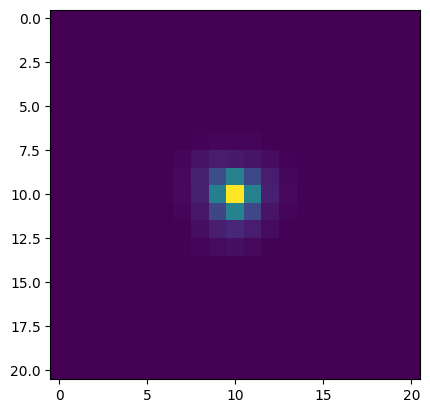

In [32]:
psf_size = psf_size_dictionary['VIS']
Ng = psf.shape[0] // psf_size

psfs = psf.reshape(Ng, psf_size, Ng, psf_size)
psfs = psfs.transpose(0, 2, 1, 3)
central = psfs[Ng//2 - 20:Ng//2 + 20, Ng//2 - 20:Ng//2 + 20]
mean_psf = np.mean(central, axis=(0, 1))
mean_psf /= mean_psf.sum()
plt.imshow(mean_psf)
plt.show()

In [33]:
file = glob.glob(f'{location}/{field}/VIS_*.fits')[0]
with fits.open(file, memmap=True) as hdul:
    hdu = hdul[0]
    image = hdu.data
    wcs = WCS(hdu.header)
    print(hdu.header)
    nx = hdu.header["NAXIS1"]
    ny = hdu.header["NAXIS2"]
pixel_scales = proj_plane_pixel_scales(wcs) * u.deg 
print("Pixel scales:", pixel_scales)
pixel_scales_arcsec = pixel_scales.to(u.arcsec)
pixel_scale_euclid = pixel_scales_arcsec.mean().value
print("Mean pixel scale (arcsec/pixel):", pixel_scale_euclid)
x_c, y_c = wcs.wcs_world2pix(ra_reference, dec_reference, 0, ra_dec_order=True)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                19200                                                  NAXIS2  =                19200                                                  EQUINOX =        2000.00000000 / Mean equinox                                   RADESYS = 'ICRS    '           / Astrometric system                             CTYPE1  = 'RA---TAN'           / WCS projection type for this axis              CUNIT1  = 'deg     '           / Axis unit                                      CRVAL1  =   5.298695150000E+01 / World coordinate on this axis                  CRPIX1  =                 9600 / Reference pixel on this axis                   CD1_1   =  -2.777777777778E-05 / Linear projection matrix                       CD1_2   =   0.000000000000E+00 / Linear 

In [34]:
def gaussian_2d(xy, amplitude, sigma, x0, y0):
    x, y = xy
    r_2 = (x - x0)**2 + (y - y0)**2
    g = amplitude * np.exp(
        -r_2/(2*sigma**2)
    )
    return g.ravel()

In [35]:
original_sizes = np.linspace(2, 30, 30)
size = 64
deconv = PSFDeconvolver(mean_psf)
deconv.prepare([size, size])
weight_sigmas = np.full(len(original_sizes), np.nan)
for i,original_size in enumerate(original_sizes):
    weight = gaussian_weight(size, size, size / 2, size / 2, original_size)
    weight_rescale = deconv.deconvolve(weight, size)
    y = np.arange(weight_rescale.shape[0])
    x = np.arange(weight_rescale.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten image and coordinates
    xdata = np.vstack((x.ravel(), y.ravel()))
    ydata = weight_rescale.ravel()

    amplitude_guess = np.max(weight_rescale)
    x0_guess = np.argmax(np.sum(weight_rescale, axis=0))
    y0_guess = np.argmax(np.sum(weight_rescale, axis=1))
    sigma_guess = original_size

    initial_guess = [amplitude_guess, sigma_guess, x0_guess, y0_guess]

    popt, _ = curve_fit(gaussian_2d, xdata, ydata, p0=initial_guess)
    amplitude, weight_sigma, x0, y0 = popt
    weight_sigmas[i] = weight_sigma

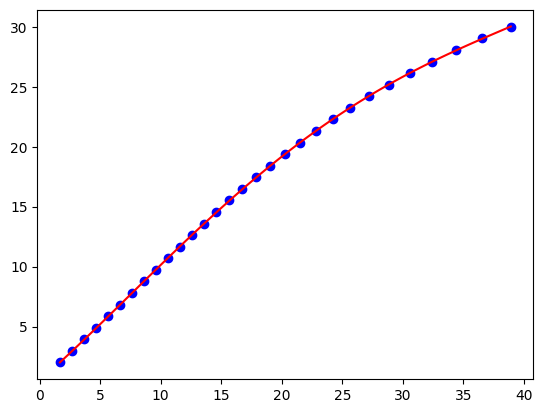

In [36]:
n = 4
coeffs = np.polyfit(np.abs(weight_sigmas[~np.isnan(weight_sigmas)]), original_sizes[~np.isnan(weight_sigmas)], n)
f = Polynomial(coeffs[::-1])  # reverse order

# Evaluate
x_new = np.linspace(np.nanmin(np.abs(weight_sigmas)), np.nanmax(np.abs(weight_sigmas)), 100)
y_fit = f(x_new)
plt.scatter(np.abs(weight_sigmas), original_sizes, color='blue')
plt.plot(x_new, y_fit, color='red')
plt.show()

In [37]:
amplitude_guess = np.mean(image[:3400, :3400])
sigma_guess = 3.5
initial_guess = [amplitude_guess, sigma_guess]

In [ ]:
size = 64
aperture_size = np.full(len(x_c), np.nan)
for i, (x_center, y_center) in enumerate(tqdm(zip(x_c, y_c), total=len(x_c))):
    x0 = int(round(x_center))
    y0 = int(round(y_center))

    # bounds (clip to image)
    x_min = max(0, x0 - size//2)
    x_max = min(nx, x0 + size//2 + 1)
    y_min = max(0, y0 - size//2)
    y_max = min(ny, y0 + size//2 + 1)

    cutout = image[y_min:y_max, x_min:x_max]

    x_center_cutout = x_center - x_min
    y_center_cutout = y_center - y_min

    # local coordinate grid
    y, x = np.mgrid[y_min:y_max, x_min:x_max]
    try:
        popt, _ = curve_fit(
            lambda xy, A, s: gaussian_2d(xy, A, s, x_center, y_center),
            (x, y),
            cutout.ravel(),
            p0=initial_guess
        )
        aperture_size[i] = f(np.abs(popt[1])) * pixel_scale_euclid
        if i % 5000 == 0:
            gc.collect()
    except RuntimeError:
        # print('error')
        aperture_size[i] = np.inf

 27%|██▋       | 25796/96164 [01:04<03:07, 375.45it/s]

error


 76%|███████▌  | 72778/96164 [03:03<01:02, 372.02it/s]

error


 76%|███████▋  | 73414/96164 [03:05<01:01, 370.06it/s]

error


 77%|███████▋  | 74247/96164 [03:07<01:07, 325.05it/s]

error


 78%|███████▊  | 74900/96164 [03:09<00:59, 355.36it/s]

error


 82%|████████▏ | 78508/96164 [03:18<00:51, 342.76it/s]

error


 85%|████████▍ | 81328/96164 [03:26<00:43, 344.81it/s]

error


 86%|████████▌ | 82455/96164 [03:29<00:37, 367.65it/s]

error


 89%|████████▉ | 85607/96164 [03:37<00:28, 368.02it/s]

error


 89%|████████▉ | 86013/96164 [03:38<00:31, 323.91it/s]

error


 90%|████████▉ | 86373/96164 [03:39<00:32, 304.58it/s]

error


 90%|█████████ | 87001/96164 [03:41<00:25, 357.65it/s]

error


 91%|█████████▏| 87781/96164 [03:43<00:24, 341.71it/s]

error


 96%|█████████▌| 91952/96164 [03:53<00:10, 386.23it/s]

error


100%|██████████| 96164/96164 [04:04<00:00, 394.00it/s]


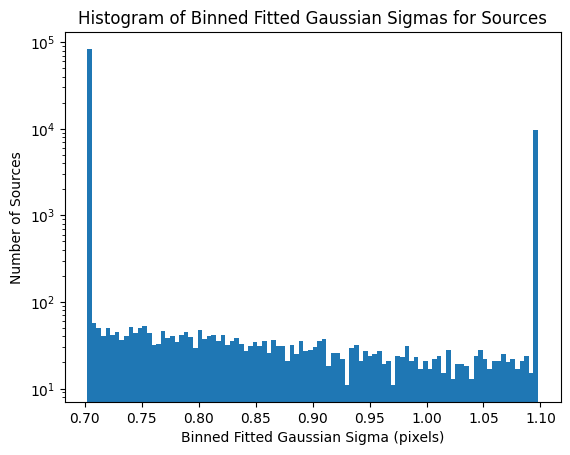

In [40]:
bins = np.linspace(.7, 1.1, 100)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# prepare array
sigma_binned = np.full_like(aperture_size, np.nan, dtype=float)

# mask valid (non-NaN) entries
mask = ~np.isnan(aperture_size)

# digitize only valid entries
bin_idx = np.digitize(aperture_size[mask], bins) - 1
bin_idx = np.clip(bin_idx, 0, len(bin_centers) - 1)

# assign binned values
sigma_binned[mask] = bin_centers[bin_idx]
plt.hist(sigma_binned[~np.isnan(sigma_binned)], bins=bin_centers)
plt.xlabel('Binned Fitted Gaussian Sigma (pixels)')
plt.ylabel('Number of Sources')
plt.title('Histogram of Binned Fitted Gaussian Sigmas for Sources')
plt.yscale('log')
plt.show()

In [20]:
fluxes = {}

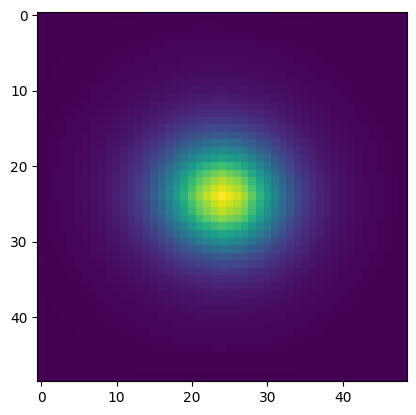

find noise square


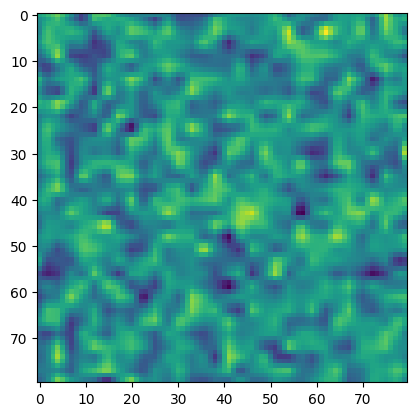

create rms
find covariance


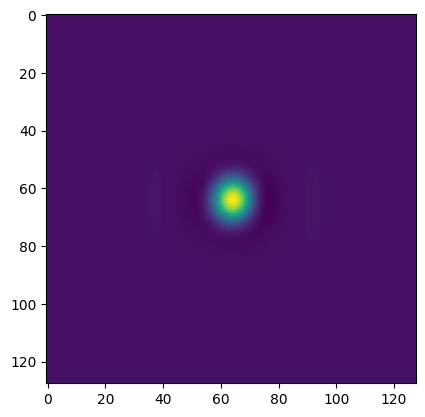

started photometry


Measuring flux: 100%|██████████| 96164/96164 [00:30<00:00, 3175.96it/s]


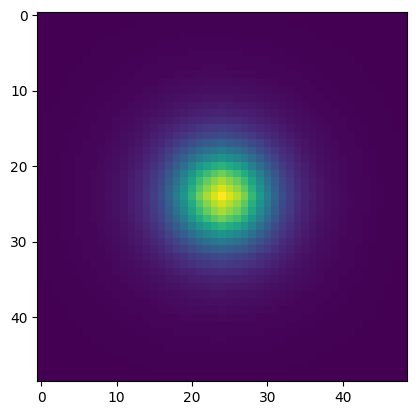

find noise square


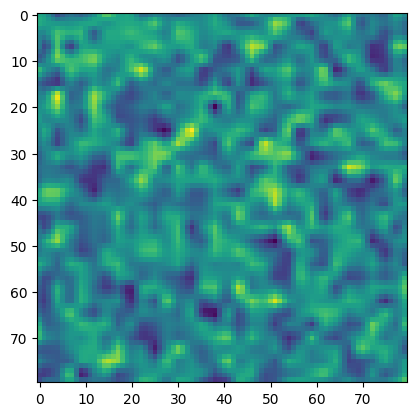

create rms
find covariance


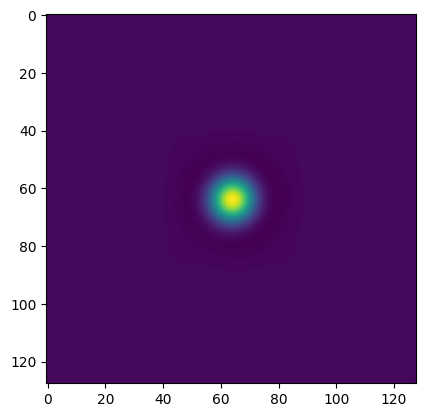

started photometry


Measuring flux: 100%|██████████| 96164/96164 [00:28<00:00, 3337.72it/s]


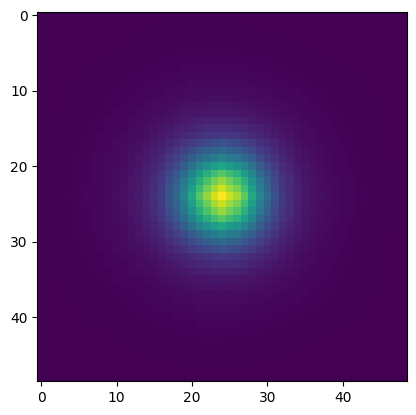

find noise square


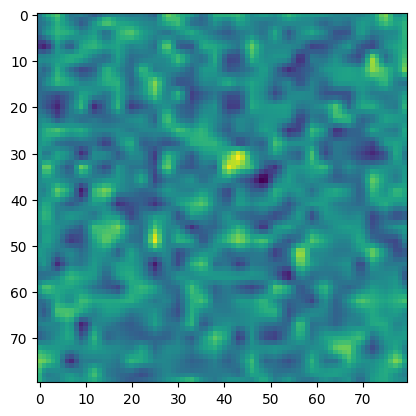

create rms
find covariance


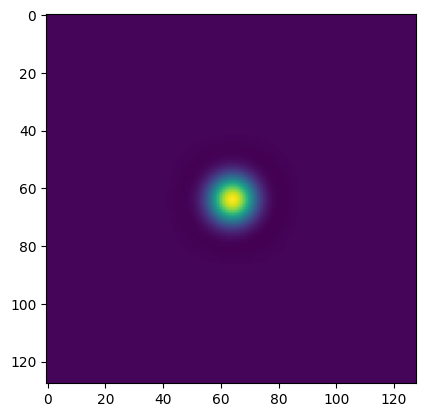

started photometry


Measuring flux: 100%|██████████| 96164/96164 [00:28<00:00, 3360.23it/s]


In [21]:
for filter in ['DES-G', 'DES-R', 'DES-I']:
    file = glob.glob(f'{location}/{field}/{filter}_*.fits.gz')[0]
    with fits.open(file, memmap=True) as hdul:
        hdu = hdul[0]
        zeropoint = hdu.header["MAGZERO"]
        image_conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 1e9
        image = hdu.data
        wcs = WCS(hdu.header)

    centers = wcs.wcs_world2pix(
            ra_reference, dec_reference, 0, ra_dec_order=True
            )
    
    file = glob.glob(f'{location}/{field}/EUC_MER_MOSAIC-{filter}-RMS_*.fits')[0]
    with fits.open(file, memmap=False) as hdul:
        hdu = hdul[0]
        zeropoint = hdu.header["MAGZERO"]
        rms_conversion_factor = 10 ** ((8.90 - zeropoint) / 2.5) * 1e9
        rms = hdu.data
    
    file = glob.glob(f'{location}/{field}/EUC_MER_CATALOG-PSF-{filter}_*.fits')[0]
    with fits.open(file, memmap=True) as hdul:
        psf = hdul[1].data
    psf_size = psf_size_dictionary[filter]
    Ng = psf.shape[0] // psf_size

    psfs = psf.reshape(Ng, psf_size, Ng, psf_size)
    psfs = psfs.transpose(0, 2, 1, 3)
    central = psfs[Ng//2 - 20:Ng//2 + 20, Ng//2 - 20:Ng//2 + 20]
    mean_psf = np.mean(central, axis=(0, 1))
    mean_psf /= mean_psf.sum()
    plt.imshow(mean_psf)
    plt.show()

    size = 128
    lag = 8
    noise = NoiseModel(
        image=image,
        rms=rms,
        image_conversion_factor=image_conversion_factor,
        rms_conversion_factor=rms_conversion_factor,
    )
    print('find noise square')
    noise.find_noise_square(80, image[:3400, :3400])
    plt.imshow(noise.noise_square)
    plt.show()
    print('create rms')
    noise.create_poisson_image()
    print('find covariance')
    noise.set_noise_covariance(lag)

    deconv = PSFDeconvolver(mean_psf)
    deconv.prepare(image_shape=(size, size), K=1e-8)
    weight = gaussian_weight(
                        size,
                        size,
                        size / 2,
                        size / 2,
                        np.nanmedian(sigma_binned) / pixel_scale_euclid,
                    )

    weight_rescale = deconv.deconvolve(weight, size)
    plt.imshow(weight_rescale)
    plt.show()
    print('started photometry')
    phot = GAAPPhotometry(
        image=image,
        centers=np.asarray(centers),
        sigmas=sigma_binned,
        pixel_scale=pixel_scale_euclid,
        image_conversion_factor=image_conversion_factor,
    )

    phot.measure(size, lag, noise, deconv)
    fluxes[f'{filter}'] = phot.flux
    fluxes[f'{filter}_sigma'] = np.sqrt(phot.variance)

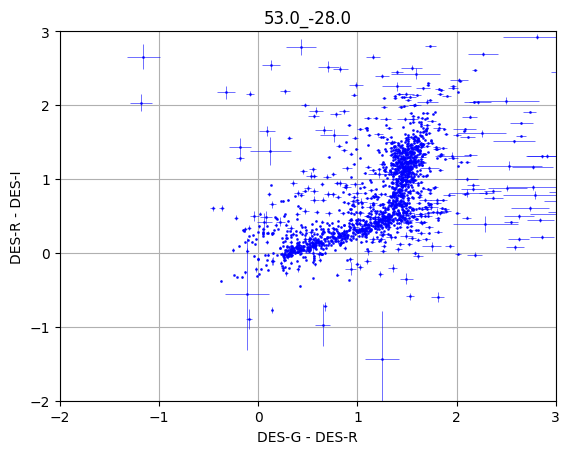

In [22]:
filter_1 = 'DES-G'   # e.g., master_table column name
filter_2 = 'DES-R'
filter_3 = 'DES-R'
filter_4 = 'DES-I'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

# Select star based on MER catalog
gaap_error = xerr**2 + yerr**2
mask = (cat['POINT_LIKE_PROB'] >= 0.5) & (gaap_error < 1)
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
)

plt.title(f'{field}')
plt.xlabel(f'{filter_1} - {filter_2}')
plt.ylabel(f'{filter_3} - {filter_4}')
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.grid(True)
plt.show()

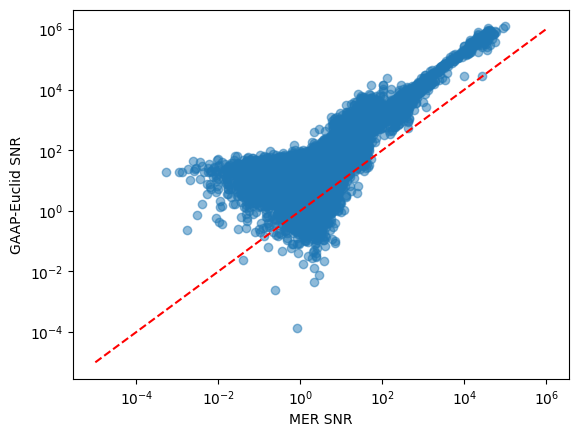

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9894580927363829
Average SNR improvement factor (GAAP-Euclid / MER): 19.857196969309417


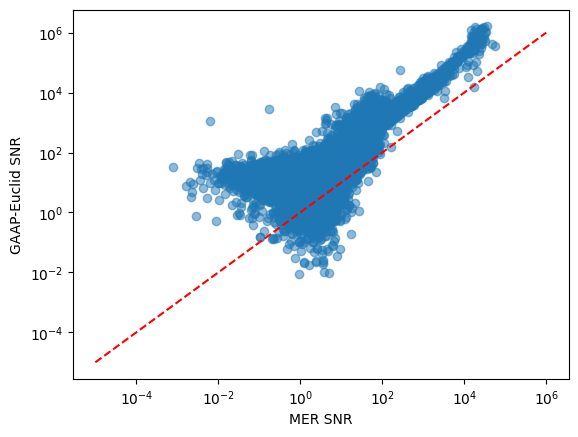

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9882280119295481
Average SNR improvement factor (GAAP-Euclid / MER): 17.80143853075313


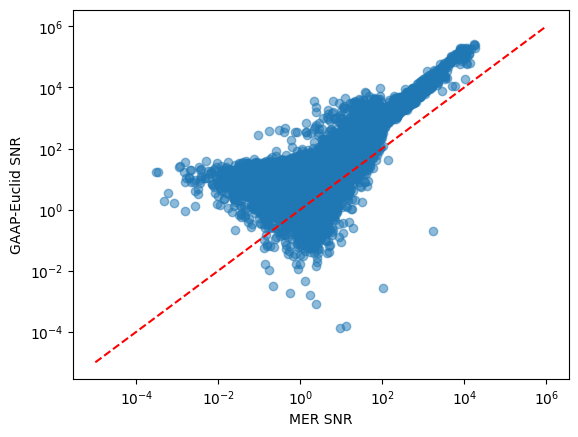

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9774282205718964
Average SNR improvement factor (GAAP-Euclid / MER): 15.667797246295557


In [28]:
for filter in ['G', 'R', 'I']:
    snr_meer = cat[f'FLUX_{filter}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter}_EXT_DECAM_4FWHM_APER']
    snr_gaap_euclid = fluxes[f'DES-{filter}']/fluxes[f'DES-{filter}_sigma']
    cutoff_snr = 1e-4
    mask = (snr_meer > cutoff_snr) & (snr_gaap_euclid > cutoff_snr) & (np.isfinite(snr_gaap_euclid)) & (np.isfinite(snr_meer))
    plt.scatter(snr_meer[mask],
                snr_gaap_euclid[mask],
                alpha=0.5)
    plt.plot([cutoff_snr*0.1 + 1e-16, 1e6], [cutoff_snr*0.1 + 1e-16, 1e6], 'r--')
    plt.xlabel('MER SNR')
    plt.ylabel('GAAP-Euclid SNR')
    plt.loglog()
    plt.show()
    print("Percent of sources where GAAP-Euclid SNR > MER SNR:", np.nansum(snr_gaap_euclid[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap_euclid[mask])))
    print("Average SNR improvement factor (GAAP-Euclid / MER):", np.nanmean(snr_gaap_euclid[mask] / snr_meer[mask]))

In [24]:
for filter in ['g', 'r', 'i']:
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [f for f in files if not f.endswith("psf.fits")][0]
    psf_file = [f for f in files if f.endswith("psf.fits")][0]
    with fits.open(image_file, memmap=True) as hdul:
        hdu = hdul[1]
        image = hdu.data
        wcs = WCS(hdu.header)
    with fits.open(psf_file, memmap=True) as hdul:
        psf = hdul[0].data
    
    centers = wcs.wcs_world2pix(
        ra_reference, dec_reference, 0, ra_dec_order=True
    )
    size = 64
    lag = 8
    noise = NoiseModel(
        image=image
    )
    noise.find_noise_square()
    noise.create_poisson_image()
    noise.set_noise_covariance(lag)

    deconv = PSFDeconvolver(psf)
    deconv.prepare(image_shape=(size, size))
    weight = gaussian_weight(
                        size,
                        size,
                        size / 2,
                        size / 2,
                        np.nanmedian(sigma_binned) / pixel_scale_euclid * 0.5,
                    )
    weight_rescale = deconv.deconvolve(weight, size)
    phot = GAAPPhotometry(
        image=image,
        centers=np.asarray(centers),
        sigmas=sigma_binned,
        pixel_scale=pixel_scale_euclid * 2
    )

    phot.measure(size, lag, noise, deconv)
    fluxes[f'{filter}'] = phot.flux
    fluxes[f'{filter}_sigma'] = np.sqrt(phot.variance)


Measuring flux: 100%|██████████| 13818/13818 [00:02<00:00, 6448.76it/s]


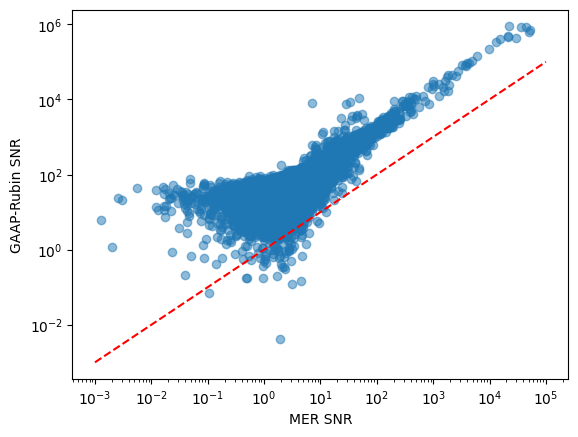

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9947741985804539
Average SNR improvement factor (GAAP-Euclid / MER): 25.283699504401792


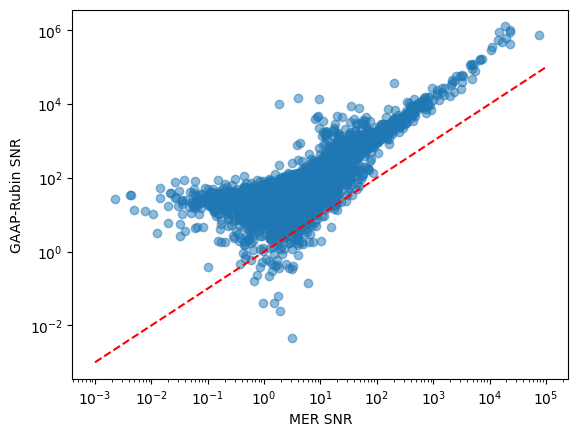

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.994172672902929
Average SNR improvement factor (GAAP-Euclid / MER): 22.649594876033518


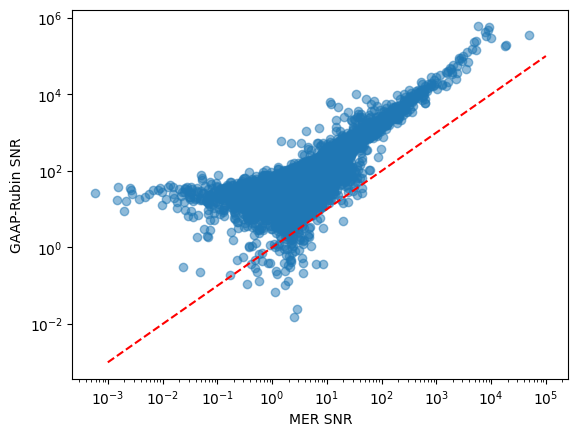

Percent of sources where GAAP-Euclid SNR > MER SNR: 0.9936475570543487
Average SNR improvement factor (GAAP-Euclid / MER): 36.24915972128779


In [41]:
for filter in ['G', 'R', 'I']:
    snr_meer = cat[f'FLUX_{filter}_EXT_DECAM_4FWHM_APER'] / cat[f'FLUXERR_{filter}_EXT_DECAM_4FWHM_APER']
    snr_gaap_euclid = fluxes[f'{filter.lower()}']/fluxes[f'{filter.lower()}_sigma']
    cutoff_snr = 0
    mask = (snr_meer > cutoff_snr) & (snr_gaap_euclid > cutoff_snr) & (np.isfinite(snr_gaap_euclid)) & (np.isfinite(snr_meer))
    plt.scatter(snr_meer[mask],
                snr_gaap_euclid[mask],
                alpha=0.5)
    plt.plot([1e-3, 1e5], [1e-3, 1e5], 'r--')
    plt.xlabel('MER SNR')
    plt.ylabel('GAAP-Rubin SNR')
    plt.loglog()
    plt.show()
    print("Percent of sources where GAAP-Euclid SNR > MER SNR:", np.nansum(snr_gaap_euclid[mask] > snr_meer[mask])/ np.sum(~np.isnan(snr_gaap_euclid[mask])))
    print("Average SNR improvement factor (GAAP-Euclid / MER):", np.nanmean(snr_gaap_euclid[mask] / snr_meer[mask]))

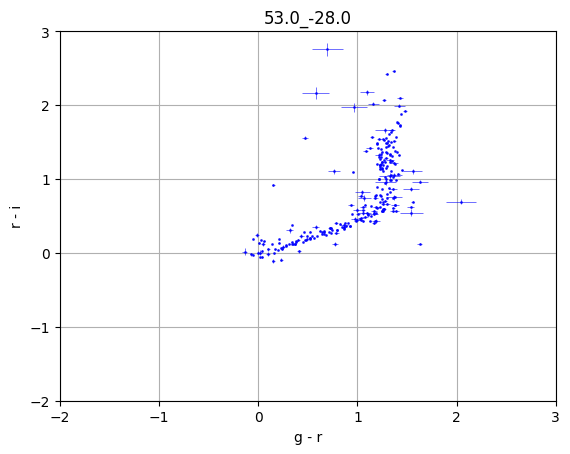

In [42]:
filter_1 = 'g'   # e.g., master_table column name
filter_2 = 'r'
filter_3 = 'r'
filter_4 = 'i'

plot_error = True

# Compute colors from master_table fluxes
x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

# Compute errors from sigma dictionary
xerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_1}_sigma'] / fluxes[filter_1])**2 +
    (fluxes[f'{filter_2}_sigma'] / fluxes[filter_2])**2
)
yerr = 2.5 / np.log(10) * np.sqrt(
    (fluxes[f'{filter_3}_sigma'] / fluxes[filter_3])**2 +
    (fluxes[f'{filter_4}_sigma'] / fluxes[filter_4])**2
)

# Select star based on MER catalog
gaap_error = xerr**2 + yerr**2
mask = (cat['POINT_LIKE_PROB'] >= 0.4)
plt.errorbar(
    x_color[mask], y_color[mask],
    xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
)

plt.title(f'{field}')
plt.xlabel(f'{filter_1} - {filter_2}')
plt.ylabel(f'{filter_3} - {filter_4}')
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.grid(True)
plt.show()